In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Notes: 

- Should have a set of inputs that are pre-processed to have training and testing sets in seperate dirs, at the resolution that you want (256) and already grayscale
- Labels to accompany these should also be in the main directory

### Should be using the 256 reduced images in grayscale as input to this model to run on GPU so shouldn't need to resize of grayscale... 

In [2]:
## Change these variables to your desired values
img_height = 256 #- these should already be done in pre-processing 
img_width = 256 #- these should already be done in pre-processing 
img_channels = 1

### Should be using the labels that come with the reduced training/testing sets

In [3]:
# These are the labels that are assigned by the paper
path_labels = "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Data/random_frames_v1_256/labels_paper/labels_paper.json"  

# Training and testing data dir
path_frames_train = "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Data/random_frames_v1_256/train/"
path_frames_test = "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Data/random_frames_v1_256/test/"

model_stable_path = './models/model.h5' # From where to load the CNN before training
model_save_path = './models/model.h5' # Where to save the CNN after training

In [4]:
#n=100000 # if you want to limit to a small subset of the data
n_train = 1000
n_test = 600
#test_size=0.1
val_size = 0.1 #fraction of training size
batch_size = 16  
epochs = 10 # For how many epochs to train

In [5]:
FLAG_DEBUG = False
FLAG_GENERATE_TABLE=True # If false: load a previously generated table - NO CODE IMPLEMENTED FOR FALSE TODO
FLAG_TRAIN=True # If false: just load a model, do not retrain
FLAG_TRAIN_IN_PRELOAD=False #if false: train with lazy loading (see details in Training Modes section) - NO CODE IMPLEMENTED FOR TRUE TODO

In [6]:
label_names=['Human', 'Interaction frontal', 'Interaction lateral', 'Interaction vertical', 'Crowded', 
             'Drink','Curiosity', 'Queue', 'Low visibility', 'Nothing']

In [7]:
# Math manipulation
import numpy as np
import pandas as pd

# Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Image processing
import cv2

# Utilities
import os
import random
import gc
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical
import codecs, json 
import re

Using TensorFlow backend.
/opt/anaconda3/envs/keras-CS762-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/keras-CS762-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/keras-CS762-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/en

In [8]:
def generate_pointer_table (path_frames, path_labels): # MEGAN REFACTOR
    pt_table = []
    
    label_file = open(path_labels)
    label_data = json.load(label_file)
    
    for frame in os.listdir(path_frames):
        if frame[-4:] == ".jpg":
            key = frame.split(".")[0]
            pt_table.append([key, label_data[key]])
        
    return pt_table

In [9]:
# Make the pointer table for testing and training images
# path_labels, path_frames_train, path_frames_test

#list_of_videos = [path_labels + i for i in sorted(os.listdir(path_labels))]
pointer_table_path_test = path_labels + 'pointer_table_test.json'
pointer_table_path_train = path_labels + 'pointer_table_train.json'
pointer_table_shuffled_path_test = path_labels + 'pointer_table_shuffled_test.json'
pointer_table_shuffled_path_train = path_labels + 'pointer_table_shuffled_train.json'
if FLAG_DEBUG: print ('Number of files: ', len(list_of_videos))
    
if FLAG_GENERATE_TABLE:   
    pt_table = generate_pointer_table(path_frames_train, path_labels)
    json.dump(pt_table, codecs.open(pointer_table_path_train, 'w', encoding='utf-8'))
    print('Train Pointer table saved')
    random.shuffle(pt_table)
    json.dump(pt_table, codecs.open(pointer_table_shuffled_path_train, 'w', encoding='utf-8'))
    print('Train Shuffled pointer table saved')
    pt_table_train_full = np.array(pt_table)
    
    
    pt_table = generate_pointer_table(path_frames_test, path_labels)
    json.dump(pt_table, codecs.open(pointer_table_path_test, 'w', encoding='utf-8'))
    print('Test Pointer table saved')
    random.shuffle(pt_table)
    json.dump(pt_table, codecs.open(pointer_table_shuffled_path_test, 'w', encoding='utf-8'))
    print('Test Shuffled pointer table saved')
    pt_table_test = np.array(pt_table)


train_max_index = int(n_train*(1 - val_size))
val_max_index = int(train_max_index + n_train*val_size)
test_max_index = n_test

pt_table_train = pt_table_train_full[0:train_max_index]
pt_table_val = pt_table_train_full[train_max_index:val_max_index]


if FLAG_DEBUG:
    print ('Train index = ',0,':', train_max_index)
    print ('Val index   = ', train_max_index,':', val_max_index)
    print ('Test index  = ', val_max_index,':', test_max_index)


#del list_of_videos, pt_table
gc.collect()

Train Pointer table saved
Train Shuffled pointer table saved
Test Pointer table saved
Test Shuffled pointer table saved


64

In [10]:
# Shouldn't need to do this... 

#def preprocess_frame(frame):
#    if type(frame) != int and len(frame.shape)>1:
#        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) # convert to greyscale
#    frame = cv2.resize (frame, (img_width, img_height), interpolation=cv2.INTER_CUBIC) # rezize
#    return frame

In [11]:
from albumentations import Compose
import albumentations as A
import random

augmentation_train = A.Compose([
    A.RandomContrast(limit=0.3, p=0.5),
    A.RandomGamma(gamma_limit=(70, 130), p=0.5),
    A.RandomBrightness(limit=0.6, p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.05, 
        scale_limit=0.05, 
        rotate_limit=10, 
        border_mode=cv2.BORDER_CONSTANT, 
        p=0.5), 
    A.ToFloat(max_value=255),
])

augmentation_test = A.Compose([
    A.ToFloat(max_value=255)
])

In [12]:
def frame_from_pointer (path, video, frame, verbose=False):
    if verbose: print ('In '+path+'/'+str(video)+'.mp4' + ', taking frame ' + str(frame))
    cap = cv2.VideoCapture(path+'/'+str(video)+'.mp4')
    if (cap.isOpened()== False):
        print("Error opening video file") 
        return -1
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
    ret, frame = cap.read() # Capture next frame
    if ret==True:
        cap.release()
        return frame
    else:
        print("Error opening frame") 
        return -1

In [13]:
def frame_from_pointer(path, vidframe):
    image = cv2.imread(path + vidframe + ".jpg")
    
    if image.shape[2] > 1: # grayscale got saved as three copies of the same image in three channels so just take one TODO - MEGAN FIX
        image, G2, G3 = cv2.split(image)
        
    return image

In [14]:
def image_generator_lazy(pt_table, batch_size, augmentation, frame_path):
    
    while True:          # Select files (paths/indices) for the batch
        pointer_batch = pt_table[np.random.choice(pt_table.shape[0], batch_size, replace=False), :]
        batch_X = []
        batch_y = []
        
        for pointer in pointer_batch:
            frame = frame_from_pointer(path=frame_path, vidframe=pointer[0])
            #print(type(frame))
            #if type(frame) != int: print(frame.shape)
            #frame = preprocess_frame(frame)
            frame = frame.astype(np.float32) # MT added 
            frame = augmentation(image=frame)['image']
            frame = frame.reshape(frame.shape[0], frame.shape[1], img_channels)
            label = to_categorical(pointer[1], num_classes=10)
        
            batch_X.append(frame)
            batch_y.append(label)
             
        # Return a tuple of (input,output) to feed the network          
        batch_X = np.array(batch_X)
        batch_y = np.array(batch_y)
        yield(batch_X, batch_y)

        
if not FLAG_TRAIN_IN_PRELOAD:
    #get the length of the train and validation data
    ntrain = len(pt_table_train)
    nval = len(pt_table_val)

    train_generator = image_generator_lazy(pt_table_train, batch_size=batch_size, augmentation=augmentation_train, frame_path=path_frames_train)
    val_generator = image_generator_lazy(pt_table_val, batch_size=batch_size, augmentation=augmentation_test, frame_path=path_frames_train)

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

#utils
from keras_tqdm import TQDMNotebookCallback

# Models
from keras import applications
from keras.optimizers import SGD, Adam

In [16]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, img_channels)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),


    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),


    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy']) 
    
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 128)       0         
____________________

In [17]:
#model = load_model(model_stable_path) # load last stable model (can be commented to train from scrach)
initial_epoch=0 # MT added
    
if FLAG_TRAIN: 
    callback_es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=20)
    callback_cp = ModelCheckpoint(model_save_path, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

    history = model.fit_generator(train_generator,
                                  steps_per_epoch=ntrain // batch_size,
                                  epochs=initial_epoch+epochs,
                                  initial_epoch=initial_epoch,
                                  validation_data=val_generator,
                                  validation_steps=nval // batch_size,
                                  verbose=0, 
                                  callbacks=[TQDMNotebookCallback(), callback_es, callback_cp])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/56 [00:00<?, ?it/s]

2022-11-09 15:08:52.041872: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA



Epoch 00001: val_acc improved from -inf to 0.64583, saving model to ./models/model.h5


Epoch 1:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 00002: val_acc did not improve from 0.64583


Epoch 2:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 00003: val_acc did not improve from 0.64583


Epoch 3:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 00004: val_acc did not improve from 0.64583


Epoch 4:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 00005: val_acc did not improve from 0.64583


Epoch 5:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 00006: val_acc did not improve from 0.64583


Epoch 6:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 00007: val_acc did not improve from 0.64583


Epoch 7:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 00008: val_acc did not improve from 0.64583


Epoch 8:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 00009: val_acc did not improve from 0.64583


Epoch 9:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 00010: val_acc did not improve from 0.64583


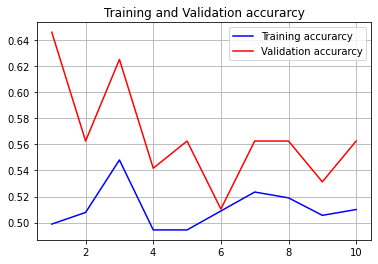

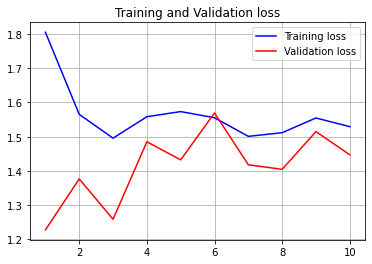

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation acc
plt.grid(True)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()

#Train and validation loss
plt.grid(True)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [19]:
#if FLAG_TRAIN:
#model = load_model(model_save_path) # load the best model saved in training phase

In [28]:
# The test should be done with pre loading, so I will take directly from the generator 
test_generator = image_generator_lazy(pt_table_test, batch_size=batch_size, augmentation=augmentation_test, frame_path=path_frames_test)

X_test = []
y_test = []
predictions = []
for i in range(0, int(len(pt_table_test)/batch_size)):
    X_batch, y_batch = next(test_generator)
    predictions_batch = model.predict_on_batch(X_batch)
    X_test.extend(X_batch)
    y_test.extend(y_batch)
    predictions.extend(predictions_batch)

X_test = np.array (X_test)
y_test = np.array (y_test)
predictions = np.array (predictions)

In [29]:
_, acc = model.evaluate(X_test, y_test)
print('Test acc:', acc)

2192/2192 [==============================] - 23s 10ms/step
Test acc: 0.43613138686131386


In [30]:
predictions = model.predict(X_test)

In [31]:
# Brief: evaluate the 'accuracy' as considering a hit if the true label is in one of the three most confident predictions
# Return: acc
def evaluate_minority_acc (y, y_hat):
    acc = 0
    for i in range(0, len(y), 1):
        pred_array = []
        pred_array.append(np.where(y_hat[i] == sorted(y_hat[i])[-1])[0][0])
        pred_array.append(np.where(y_hat[i] == sorted(y_hat[i])[-2])[0][0])
        pred_array.append(np.where(y_hat[i] == sorted(y_hat[i])[-3])[0][0])
        if np.argmax(y[i]) in pred_array: acc += 1
    return acc/len (y)
    
    
evaluate_minority_acc(y_test, predictions)

0.645529197080292

In [32]:
# Brief: plot the image with the predicted label, confidence and real label
def plot_image(i, prediction, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.reshape(img.shape[0], img.shape[1]))

    if np.argmax(prediction) == np.argmax(true_label):
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{}) {}, {:2.0f}% \n({})".format(
        i,
        label_names[np.argmax(prediction)],
        100*np.max(prediction),
        label_names[np.argmax(true_label)]), color=color)

# Brief: plot a bar graph with the probability of each predicted class
def plot_value_array(prediction, true_label):
    plt.grid(False)
    plt.xticks(range(10))
    thisplot = plt.bar(range(10), prediction, color="#777777")

In [33]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
if FLAG_DEBUG:
    num_rows = 160
    num_cols = 1
    num_images = num_rows*num_cols
    plt.figure(figsize=(7, 4*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], y_test[i], X_test[i])
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(predictions[i],  y_test[i])
    plt.tight_layout()
    plt.show()

Class 0: Human
Class 1: Interaction frontal
Class 2: Interaction lateral
Class 3: Interaction vertical
Class 4: Crowded
Class 5: Drink
Class 6: Curiosity
Class 7: Queue
Class 8: Low visibility
Class 9: Nothing


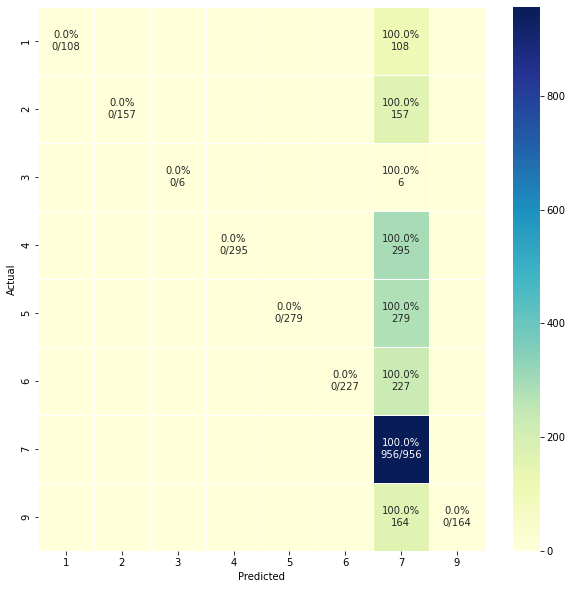

In [34]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax, linewidths=.5)

plot_cm(np.array([np.argmax(xi) for xi in y_test]), np.array([np.argmax(xi) for xi in predictions]))
_n=0
for i in label_names:
    print('Class ' + str(_n) + ': ' + i)
    _n+=1

In [35]:
#import sklearn.metrics as metrics
#print(metrics.classification_report(np.array([np.argmax(xi) for xi in y_test]), np.array([np.argmax(xi) for xi in predictions]), target_names=label_names))